# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [2]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10
matname = 'vanilla'

In [3]:
from shl_scripts.shl_experiments import SHL
help(SHL)

Help on class SHL in module shl_scripts.shl_experiments:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_width=16, datapath='database/', name_database='kodakdb', n_dictionary=324, learning_algorithm='mp', fit_tol=None, do_precision=False, do_mask=True, l0_sparseness=30, one_over_F=True, n_iter=4097, eta={'eta': 0.003, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}, homeo_method='HEH', homeo_params={'eta_homeo': 0.05, 'C': 5.0, 'nb_quant': 256, 'P_cum': None}, do_sym=False, max_patches=4096, seed=42, patch_norm=False, batch_size=512, record_each=128, n_image=None, DEBUG_DOWNSCALE=1, verbose=0, data_cache='/tmp/data_cache')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  code(self, data, dico, coding_algorithm='mp', matname=None, P_cum=None, 

In [4]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose)
data = shl.get_data(matname='data')

Extracting data..loading the data called : /tmp/data_cache/data_data
Data is of shape : (81920, 256) - done in 0.13s.


In [5]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 256)
average of patches =  -0.00019886110837833318  +/-  0.05942785266358504
average energy of data =  9.525823624625719 +/- 9.035125773839846


In [6]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : /tmp/data_cache/vanilla_dico.pkl


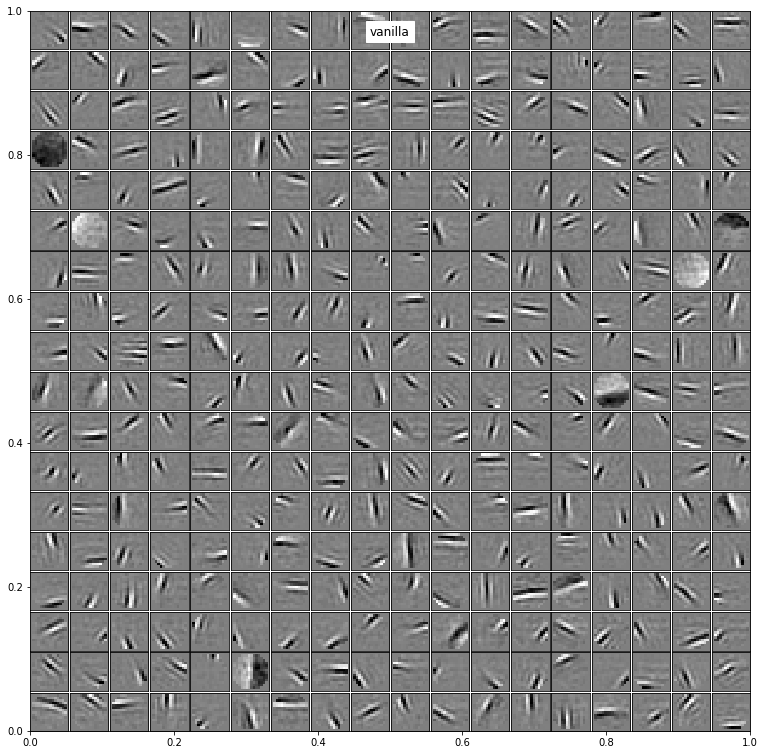

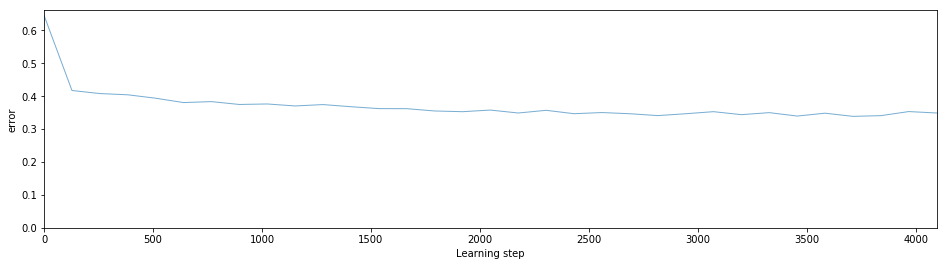

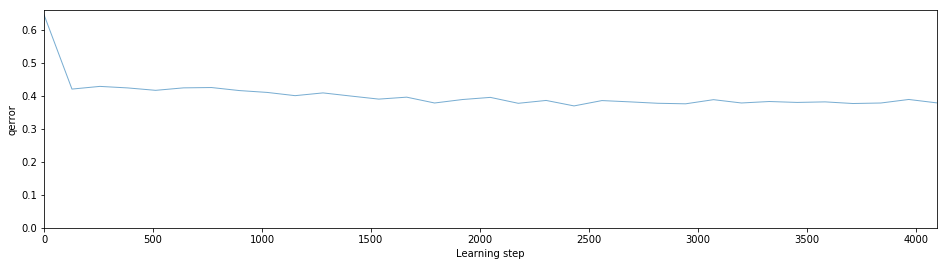

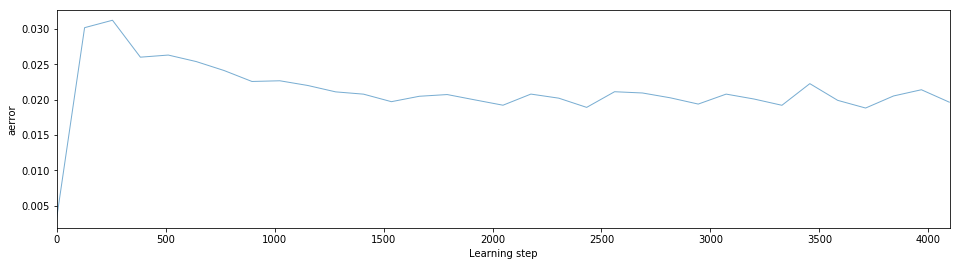

In [7]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_qerror', 'time_plot_aerror']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']
dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [8]:
help(dico)

Help on SparseHebbianLearning in module shl_scripts.shl_learn object:

class SparseHebbianLearning(builtins.object)
 |  Sparse Hebbian learning
 |  
 |  Finds a dictionary (a set of atoms) that can best be used to represent data
 |  using a sparse code.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_dictionary : int,
 |      Number of dictionary elements to extract
 |  
 |  eta : float or dict
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  n_iter : int,
 |      total number of iterations to perform
 |  
 |  eta_homeo : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  alpha_homeo : float
 |      Gives the smoothing exponent  for the homeostatic gain
 |      If equal to 1 the homeostatic learning rule learns a linear relation to
 |      variance.
 |  
 |  dictionary : array of shape (n_dictionary, n_pixels),
 |      initial value of the dictionary for warm restart scenarios
 |      Use ``None`` for a new learning.
 |  
 |  fit_algorith

In [9]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (324, 256)
average of filters =  -1.847890721391443e-06 +/- 0.005070693933538067
average energy of filters =  1.0 +/- 9.791246743253677e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [10]:
sparse_code = shl.code(data, dico, matname=matname, l0_sparseness=45)
print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

loading the code called : /tmp/data_cache/vanilla_coding.npy
number of codes, size of codewords =  (81920, 324)
average of codewords =  0.14897382245731428
average energy of codewords =  0.6912440374753067
std of the average of individual patches =  0.029954062216739658


In [11]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (81920, 256)


In [12]:
error = data - patches
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.sum(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

average of residual patches =  -0.0008589134966724546 +/- 0.012290967840711322
average energy of residual =  2.691808146431959 +/- 2.50794783693602


## Version used

In [13]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
Wed Feb 07 22:49:03 2018 CET